In [5]:
#from google.colab import drive
#drive.mount('/content/gdrive/')

!pip install --upgrade pip
!pip install scikit-image xmltodict
!pip install onnxruntime-gpu
!pip install czmodel

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.4/435.4 KB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 KB 36.4 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 2.0
    Uninstalling flatbuffers-2.0:
      Successfully uninstalled flatbuffers-2.0


In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

#import sys
#sys.path.append('/content/gdrive/MyDrive/Colab Notebooks/train_czann')

import tempfile
from tools import _extract_model
import json
from pathlib import Path
from tools._onnx_inference import OnnxInferencer
import onnxruntime as onnx_rt
from czmodel.convert import DefaultConverter
from pathlib import Path
from skimage import io
import random

# Define the parameters for loading the training data
base_directory = os.getcwd()

# place the original and label *.png images here
imgfolder = "nucleus_data/images/"

# masks images have one channel (0=background and 1=object)
maskfolder = "nucleus_data/labels"

# construct the final path to the images and labels
IMAGES_FOLDER = os.path.join(base_directory, imgfolder)
MASKS_FOLDER = os.path.join(base_directory, maskfolder)

# get the sample images
sample_images = sorted([os.path.join(IMAGES_FOLDER, f) for f in os.listdir(IMAGES_FOLDER)
                        if os.path.isfile(os.path.join(IMAGES_FOLDER, f))])

# get the maks
sample_masks = sorted([os.path.join(MASKS_FOLDER, f) for f in os.listdir(MASKS_FOLDER)
                       if os.path.isfile(os.path.join(MASKS_FOLDER, f))])

czann_file = os.path.join(base_directory, "simple_nuclei_segmodel.czann")

In [12]:
def predict_one(sess, array2d):

            array2d = array2d[np.newaxis]
            input_name = sess.get_inputs()[0].name
            output_name = sess.get_outputs()[0].name

            # ONNX can only handle float32
            array2d = array2d.astype(np.float32)
            input_dict = {input_name: array2d}
            result = sess.run([output_name], input_dict)[0]

            return result[0]

In [14]:
# select an a random image
id = random.randint(0, len(sample_images))

# extract the model information and path and to the prediction
with tempfile.TemporaryDirectory() as temp_path:

    # get the model metadata and the path
    model_metadata, model_path = DefaultConverter().unpack_model(model_file=czann_file, target_dir=Path(temp_path))

    # get model metadata as dictionary
    model_metadata_dict = model_metadata._asdict()
    for k,v in model_metadata_dict.items():
        print(k, "=", v)

    # get the input shape
    shp = model_metadata.input_shape

    # create an ONNX session and get the input shape
    # use either "CUDAExecutionProvider" or "CPUExecutionProvider"]
    sess = onnx_rt.InferenceSession(str(model_path), providers=["CPUExecutionProvider"])

model_type = ModelType.SINGLE_CLASS_SEMANTIC_SEGMENTATION
input_shape = [1024, 1024, 1]
output_shape = [1024, 1024, 2]
model_id = 29b69885-3971-4197-a8c3-74b9c920bcc1
min_overlap = [8, 8]
classes = ['Background', 'Nucleus']
model_name = Simple_Nuclei_SegmentationModel


Text(0.5, 1.0, 'Label Mask')

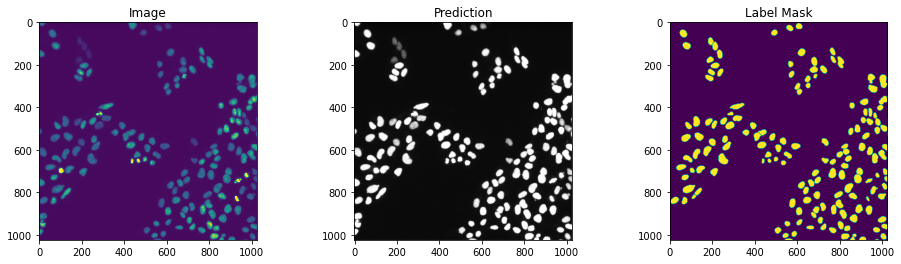

In [15]:
# just re-execute the cell to display a different image

# select an a random image
id = random.randint(0, len(sample_images))

# read images and scale
img = io.imread(sample_images[id])/(2**16 - 1)
mask = io.imread(sample_masks[id])

# cut input to fit the model
img = img[0: shp[0], 0:shp[1]]
mask = mask[0: shp[0], 0:shp[1]]

# run the actual prediction
pred = predict_one(sess, img[..., np.newaxis])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(16)

# show images and set titles
ax1.imshow(img, vmin=0, vmax=0.05)
ax2.imshow(pred[..., 1], cmap="gray")
ax3.imshow(mask)

ax1.set_title('Image')
ax2.set_title('Prediction')
ax3.set_title('Label Mask')